In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tp = y_true_tmp[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    return tp / (tp + fn)

def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tn = y_true_tmp[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    return tn / (tn + fp)

# def balanced_acc(sensitivity, specificity):
#     return (sensitivity + specificity) / 2.0

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred)) / 2.0

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

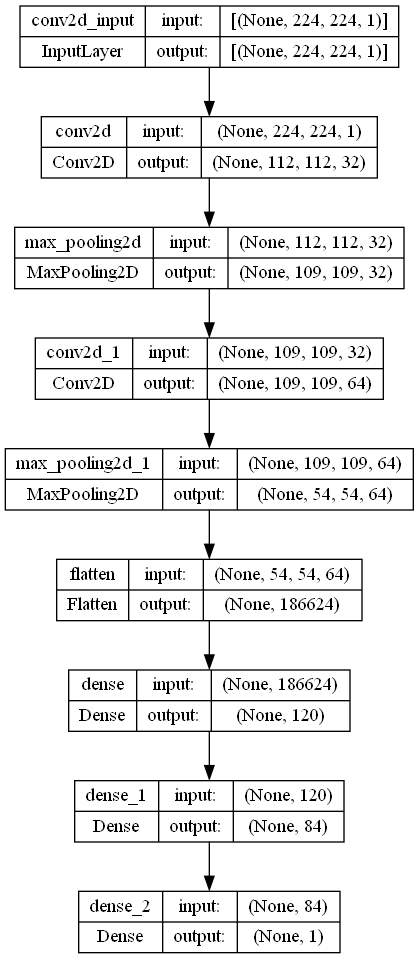

In [5]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

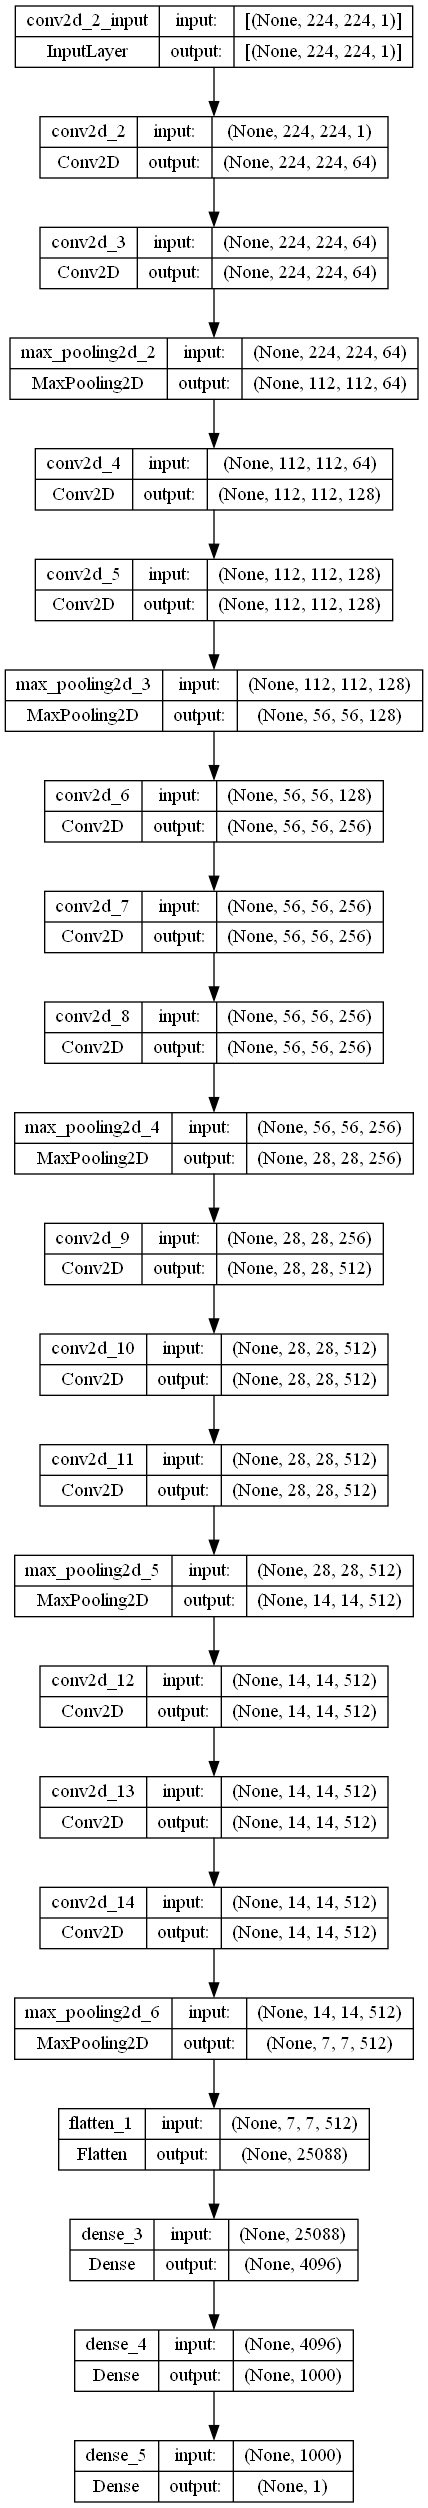

In [6]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

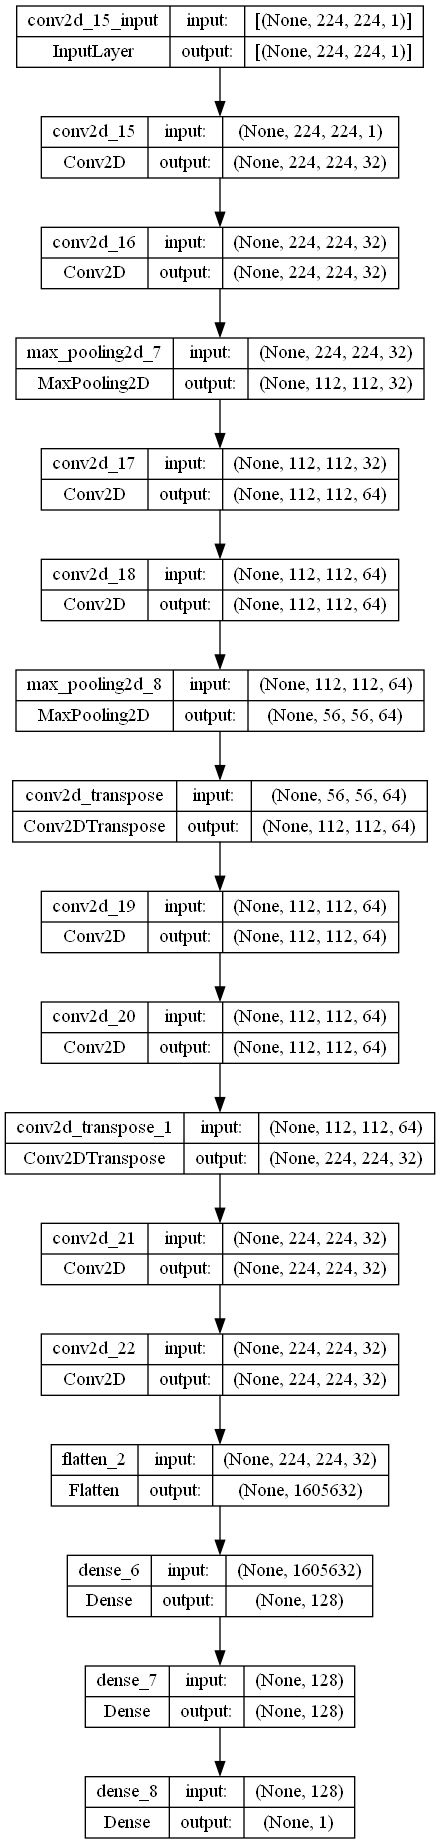

In [7]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

In [8]:
#opt = keras.optimizers.Adam(learning_rate=0.0003)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    sensitivity,
    specificity,
    balanced_acc
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [9]:
# le_net_5_k = KerasClassifier(le_net_5, epochs=100, batch_size=20, verbose=2)
# vgg_16_k = KerasClassifier(vgg_16, epochs=100, batch_size=20, verbose=2)
# lu_net_k = KerasClassifier(lu_net, epochs=100, batch_size=20, verbose=2)

# sd = seed(time())
# RSKFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=sd)

In [10]:
def fit_evaluate(model, X_train, X_test, y_train, y_test, batch_size=32, epochs=100, validation_split=0.2):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    scores_model =model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics):
    fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
    for i, metric in zip(range(len(metrics)), metrics):
        ax[i].plot(range(1, 101), df[metric], 'b-', label='Train')
        ax[i].plot(range(1, 101), df[f'val_{metric}'], 'r-', label='Validation')
        ax[i].set_title(metric)
        ax[i].legend()
    plt.show()

In [11]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

c:\Users\kmart\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
4/4 [==============================] - 7s 2s/step - loss: 327.6336 - precision: 0.6230 - binary_accuracy: 0.5203 - recall: 0.5135 - sensitivity: 0.5139 - specificity: 0.4821 - val_loss: 154.0993 - val_precision: 0.5806 - val_binary_accuracy: 0.5806 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 41.4117 - precision: 0.6061 - binary_accuracy: 0.5691 - recall: 0.8108 - sensitivity: 0.7812 - specificity: 0.2273 - val_loss: 0.7663 - val_precision: 1.0000 - val_binary_accuracy: 0.5161 - val_recall: 0.1667 - val_sensitivity: 0.1667 - val_specificity: 1.0000
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.6577 - precision: 0.9429 - binary_accuracy: 0.6504 - recall: 0.4459 - sensitivity: 0.4532 - specificity: 0.9542 - val_loss: 0.6965 - val_precision: 0.8000 - val_binary_accuracy: 0.8065 - val_recall: 0.8889 - val_sensitivity: 0.8889 - val_specificity: 0.6923
E

In [12]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 76s 18s/step - loss: 1740.6058 - precision: 0.6529 - binary_accuracy: 0.5820 - recall: 0.6810 - sensitivity: 0.7024 - specificity: 0.2727 - val_loss: 0.6962 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4194 - val_recall: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
4/4 [==============================] - 62s 15s/step - loss: 1.0582 - precision: 0.5934 - binary_accuracy: 0.5366 - recall: 0.7297 - sensitivity: 0.7500 - specificity: 0.2500 - val_loss: 0.6912 - val_precision: 0.5806 - val_binary_accuracy: 0.5806 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 62s 16s/step - loss: 0.6924 - precision: 0.5982 - binary_accuracy: 0.5772 - recall: 0.9054 - sensitivity: 0.9142 - specificity: 0.0874 - val_loss: 0.6908 - val_precision: 0.5806 - val_binary_accuracy: 0.5806 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_speci

In [13]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 48s 12s/step - loss: 0.6949 - precision: 0.6369 - binary_accuracy: 0.6138 - recall: 0.8621 - sensitivity: 0.7500 - specificity: 0.2500 - val_loss: 0.7093 - val_precision: 0.5806 - val_binary_accuracy: 0.5806 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 36s 9s/step - loss: 0.6928 - precision: 0.6016 - binary_accuracy: 0.6016 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - val_loss: 0.6812 - val_precision: 0.5806 - val_binary_accuracy: 0.5806 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 35s 9s/step - loss: 0.6885 - precision: 0.6016 - binary_accuracy: 0.6016 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - val_loss: 0.6874 - val_precision: 0.5806 - val_binary_accuracy: 0.5806 - val_recall: 1.0000 - val_sensitivity: 1.0000 - val_specificit

In [14]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net['balanced_accuracy'] = balanced_acc(df_lu_net['sensitivity'].values, df_lu_net['specificity'].values)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,balanced_accuracy
0,0.694919,0.636943,0.613757,0.862069,0.75,0.25,0.709289,0.580645,0.580645,1.0,1.0,0.0,0.5
1,0.692842,0.601626,0.601626,1.000000,1.00,0.00,0.681201,0.580645,0.580645,1.0,1.0,0.0,0.5
2,0.688499,0.601626,0.601626,1.000000,1.00,0.00,0.687369,0.580645,0.580645,1.0,1.0,0.0,0.5
3,0.680038,0.601626,0.601626,1.000000,1.00,0.00,0.680218,0.580645,0.580645,1.0,1.0,0.0,0.5
4,0.678772,0.601626,0.601626,1.000000,1.00,0.00,0.689730,0.580645,0.580645,1.0,1.0,0.0,0.5


In [15]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16['balanced_accuracy'] = balanced_acc(df_vgg_16['sensitivity'].values, df_vgg_16['specificity'].values)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,balanced_accuracy
0,1740.605835,0.652893,0.582011,0.681035,0.702381,0.272727,0.696169,0.000000,0.419355,0.0,0.0,1.0,0.487554
1,1.058242,0.593407,0.536585,0.729730,0.750000,0.250000,0.691246,0.580645,0.580645,1.0,1.0,0.0,0.500000
2,0.692397,0.598214,0.577236,0.905405,0.914160,0.087413,0.690770,0.580645,0.580645,1.0,1.0,0.0,0.500786
3,0.679169,0.601626,0.601626,1.000000,1.000000,0.000000,0.790009,0.580645,0.580645,1.0,1.0,0.0,0.500000
4,0.712918,0.601626,0.601626,1.000000,1.000000,0.000000,0.689035,0.580645,0.580645,1.0,1.0,0.0,0.500000


In [16]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5['balanced_accuracy'] = balanced_acc(df_le_net_5['sensitivity'].values, df_le_net_5['specificity'].values)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,sensitivity,specificity,val_loss,val_precision,val_binary_accuracy,val_recall,val_sensitivity,val_specificity,balanced_accuracy
0,327.633606,0.622951,0.520325,0.513514,0.513889,0.482143,154.099319,0.580645,0.580645,1.000000,1.000000,0.000000,0.498016
1,41.411720,0.606061,0.569106,0.810811,0.781250,0.227273,0.766289,1.000000,0.516129,0.166667,0.166667,1.000000,0.504261
2,0.657680,0.942857,0.650406,0.445946,0.453216,0.954167,0.696490,0.800000,0.806452,0.888889,0.888889,0.692308,0.703692
3,0.555030,0.790123,0.780488,0.864865,0.864607,0.651877,0.805455,0.620690,0.645161,1.000000,1.000000,0.153846,0.758242
4,0.417462,0.787234,0.837398,1.000000,1.000000,0.586538,1.147471,0.857143,0.580645,0.333333,0.333333,0.923077,0.793269


KeyError: 'val_balanced_accuracy'

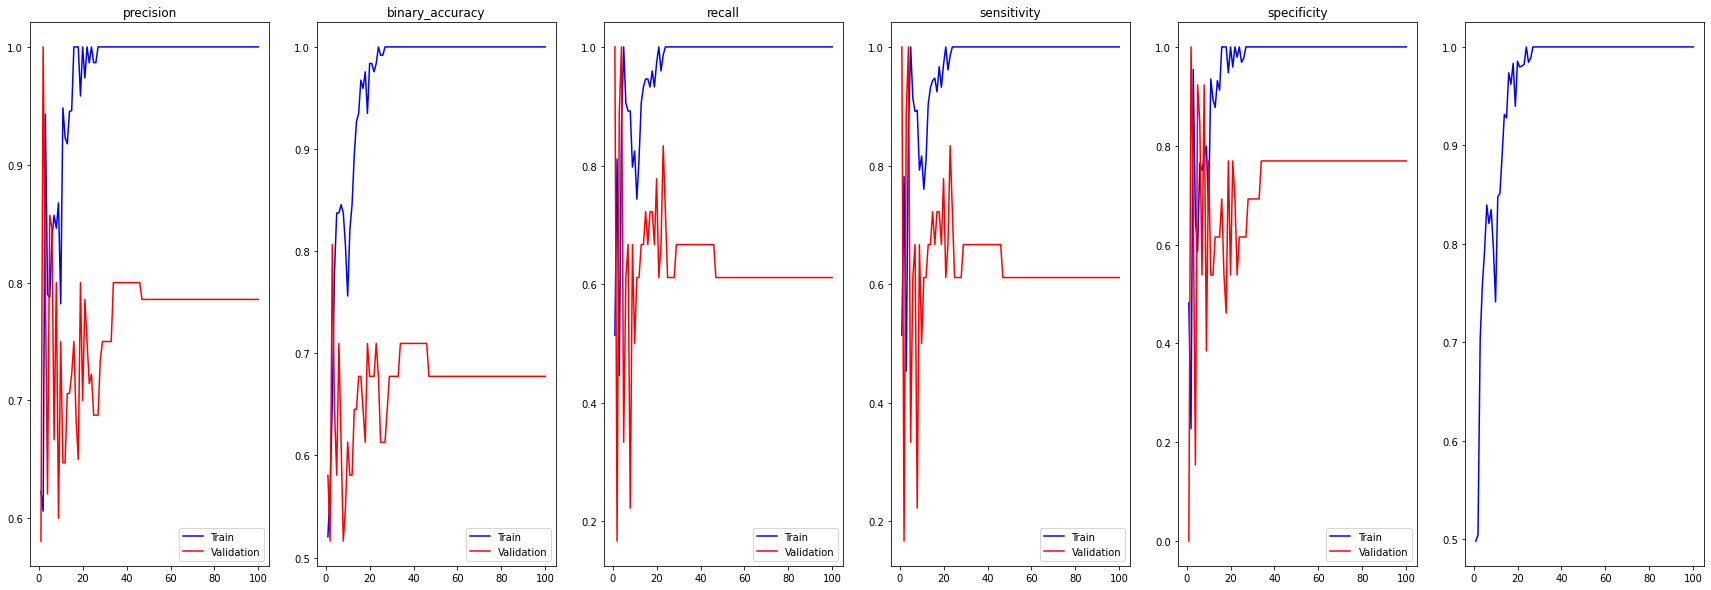

In [17]:
metrics = ['precision', 'binary_accuracy', 'recall', 'sensitivity', 'specificity', 'balanced_accuracy']
graph_history(df_le_net_5, metrics)

In [ ]:
graph_history(df_lu_net, metrics)

In [ ]:
graph_history(df_vgg_16, metrics)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
sensitivities, specificities = [scores[4] for score in scores], [scores[5] for score in scores]
baccs = [balanced_acc(sens, spec) for sens, spec in zip(sensitivities, specificities)]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Sensitivity':sensitivities,
    'Specificity':specificities,
    'Balanced Accuracy':baccs
})
scores_df.head()

In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [ ]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-15, 15], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

X_aug, y_aug = data_augmentation(X, classes, 20, imgs_trans)

In [ ]:
N, SIZE_H, SIZE_V = X_aug.shape
N_CLASSES = len(np.unique(y_aug))
print(f'X shape {X_aug.shape}')
print(f'Num classes: {N_CLASSES}')

In [ ]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, random_state=sd, shuffle=True)

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, y_train, y_test)

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, y_train, y_test)

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net['balanced_accuracy'] = balanced_acc(df_lu_net['sensitivity'].values, df_lu_net['specificity'].values)
df_lu_net.head()

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16['balanced_accuracy'] = balanced_acc(df_vgg_16['sensitivity'].values, df_vgg_16['specificity'].values)
df_vgg_16.head()

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5['balanced_accuracy'] = balanced_acc(df_le_net_5['sensitivity'].values, df_le_net_5['specificity'].values)
df_le_net_5.head()

In [ ]:
metrics = ['precision', 'binary_accuracy', 'recall', 'sensitivity', 'specificity', 'balanced_accuracy']
graph_history(df_le_net_5, metrics)

In [ ]:
graph_history(df_lu_net, metrics)

In [ ]:
graph_history(df_vgg_16, metrics)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
sensitivities, specificities = [scores[4] for score in scores], [scores[5] for score in scores]
baccs = [balanced_acc(sens, spec) for sens, spec in zip(sensitivities, specificities)]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Sensitivity':sensitivities,
    'Specificity':specificities,
    'Balanced Accuracy':baccs
})
scores_df.head()

In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')